### Import the necessary libraries

In [63]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os

### Some utils for images and plots

In [64]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

### Configurations

In [65]:
#training_dir = "UTsig"
training_csv = "train.csv"
testing_csv = "test.csv"
#testing_dir = "UTsig"
batch_size = 8
epochs = 20

### Contrastive loss function

In [66]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

### Preprocessing and loading the dataset

In [67]:
class SiameseDataset:
    def __init__(self, training_csv=None, 
                 #training_dir=None, 
                 transform=None,
                 trunc=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df=self.train_df
        #self.train_df.columns = ["image1", "image2", "label"]
        #self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        #image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        #image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])
        image1_path = self.train_df.iat[index, 0]
        image2_path = self.train_df.iat[index, 1]

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

### Load the the dataset from raw image folders

In [68]:
siamese_dataset = SiameseDataset(
    training_csv,
    #training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
    trunc=50000
)
siamese_dataset.train_df[:50000]

eval_dataset = SiameseDataset(
    testing_csv,
    #training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
    trunc=10000
)


,Image1,Image2,label
0,./UTSig/Genuine/89/13.png,./UTSig/Genuine/89/12.png,0
1,./UTSig/Genuine/25/10.png,./UTSig/Genuine/25/27.png,0
2,./UTSig/Genuine/33/6.png,./UTSig/Genuine/33/17.png,0
3,./UTSig/Genuine/50/6.png,./UTSig/Forgery/Simple/50/53.png,1
4,./UTSig/Genuine/2/1.png,./UTSig/Forgery/Simple/2/44.png,1
...,...,...,...
9995,./UTSig/Genuine/70/21.png,./UTSig/Forgery/Simple/70/65.png,1
9996,./UTSig/Genuine/85/1.png,./UTSig/Forgery/Simple/85/31.png,1
9997,./UTSig/Genuine/20/4.png,./UTSig/Genuine/20/19.png,0
9998,./UTSig/Genuine/85/16.png,./UTSig/Genuine/85/3.png,0


### Viewing the sample of images and to check whether its loading properly

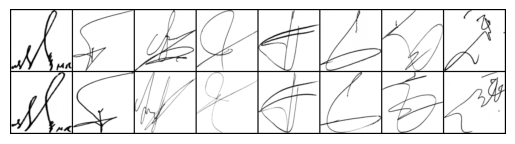

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [69]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### Create a siamese network

In [70]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

### Load the dataset as pytorch tensors using dataloader

In [71]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size) 
eval_dataloader = DataLoader(eval_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size) 

### Declare Siamese Network

In [72]:
net = SiameseNetwork().cuda()

### Decalre Loss Function

In [73]:
criterion = ContrastiveLoss()

### Declare Optimizer

In [74]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

### Train the model

In [75]:
from tqdm import tqdm

def train(train_dataloader):
    loss = [] 
    iteration_number = 0
    
    # Utilisation de tqdm pour créer une barre de progression
    for i, data in enumerate(tqdm(train_dataloader, desc="Training", unit="batch", leave=False)):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())
    
    loss = np.array(loss)
    return loss.mean() / len(train_dataloader)


def eval(eval_dataloader):
    loss=[] 
    counter=[]
    iteration_number = 0
    for i, data in enumerate(eval_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      output1,output2 = net(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(eval_dataloader)


for epoch in range(1, epochs):
  print(f"-----epoch {epoch}-----")
  best_eval_loss = 9999
  train_loss = train(train_dataloader)
  eval_loss = eval(eval_dataloader)

  print(f"Training loss{train_loss}")
  print("-"*20)
  print(f"Eval loss{eval_loss}")

  if eval_loss<best_eval_loss:
    best_eval_loss = eval_loss
    print("-"*20)
    print(f"Best Eval loss{best_eval_loss}")
    torch.save(net.state_dict(), "./content/model.pth")
    print("Model Saved Successfully")

-----epoch 1-----


Training:   0%|          | 0/18339 [00:00<?, ?batch/s]c:\Users\GAD\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 

### Performance test

In [35]:
model_path = './content/model.pth'
net.load_state_dict(torch.load(model_path))
net.eval()  # Set the model to evaluation mode

correct = 0
total = 0
threshold=0.05
with torch.no_grad():  # Disable gradient calculation for evaluation
    for i, data in enumerate(eval_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        output1,output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        predicted = (euclidean_distance > threshold).float()
        predicted=predicted.reshape(-1,1)
        total += label.size(0)
        correct += torch.sum(predicted == label)

accuracy = 100 * correct / total
print(f'Accuracy of the Siamese network on the test set: {accuracy:.2f}%')

c:\Users\GAD\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of the Siamese network on the test set: 60.53%


c:\Users\GAD\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


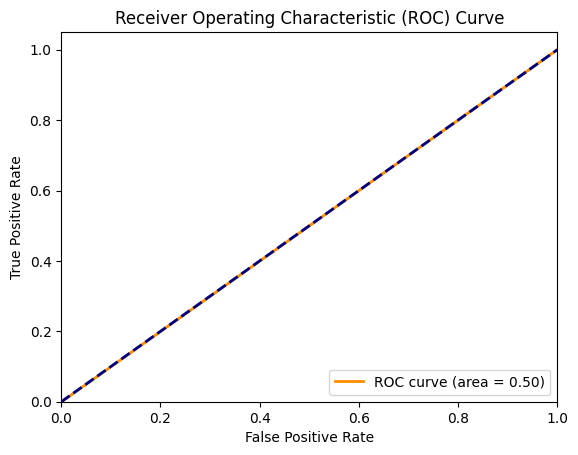

AUC: 0.50


In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_path = './content/model.pth'
net.load_state_dict(torch.load(model_path))
net.eval()

# Initialize lists to store true labels and predicted scores
true_labels = []
predicted_scores = []

# Evaluate the model on the test set
with torch.no_grad():  
    for i, data in enumerate(eval_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        # Forward pass
        output1, output2 = net(img0, img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        predicted_scores.extend(euclidean_distance.cpu().numpy())
        true_labels.extend(label.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f'AUC: {roc_auc:.2f}')